# Clustering and cell annotation

In [1]:
import scanpy as sc
import pandas as pd # for handling data frames (i.e. data tables)
import numpy as np # for handling numbers, arrays, and matrices
import matplotlib.pyplot as plt # plotting package
import seaborn as sns # plotting package

**Exercise 0**: Before we continue in this notebook with the next steps of the analysis, we need to load our results from the previous notebook using the `sc.read_h5ad` function and assign them to the variable name `adata`. Give it a try!

In [2]:
adata = sc.read_h5ad("PBMC_analysis_SIB_tutorial4.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 5469 × 3000
    obs: 'sample', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'is_doublet', 'S_score', 'G2M_score', 'phase'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pcahm', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Clustering the data helps to identify cells with similar gene expression properties that may belong to the same cell type or cell state. There are two popular clustering methods, both available in scanpy: Leiden clustering.

**Exercise 1**: Run Leiden clustering algorithm. Visualize the clusters on your UMAP representation. Are the clusters different from each method? Visualize the clusters again, this time on the tSNE embedding instead of the UMAP embedding. Are there differences in which clusters are grouped together?

In [4]:
sc.tl.leiden(adata)

/tmp/ipykernel_22873/3467744858.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


Next, you can visualize your UMAP and tSNE representations of the scRNA-seq and color by various metadata attributes (including Louvian or Leiden clusters) from the prior steps. For example:

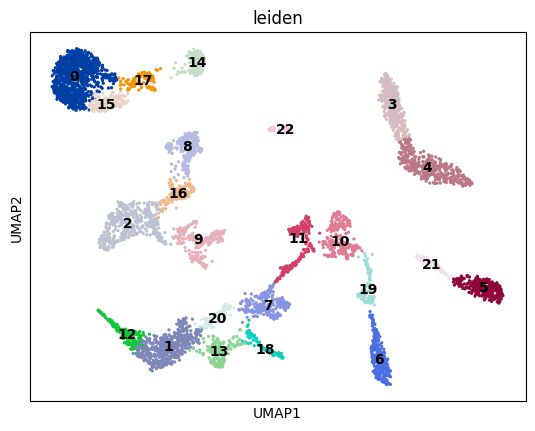

In [5]:
sc.pl.umap(adata, color="leiden",legend_loc="on data")

**Exercise 2**: How many cells do you have per cluster? Can you plot a histogram of this?

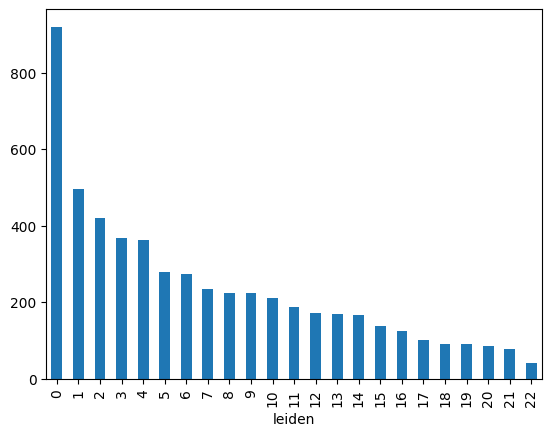

In [6]:
n_clusters = adata.obs["leiden"].value_counts()
ax = n_clusters.plot(kind="bar")
plt.show()

**Exercise 3**: Visualize some of the other metadata on the UMAP embedding, including the `n_counts`, `sample`, `n_genes`, `pct_counts_mt`, and `phase` metadata found in `adata.obs`. 

Do any clusters seem to have an obvious bias towards particular attributes? This might be a sign that we want to optimize prior steps of the analysis, such as adjusting the number of principal components used in the neighborhood smoothing or regressing out particular variables. As with a pandas dataframe, you can also examine the frequency of various attributes using a command such as: `adata.obs["phase"].value_counts()`.

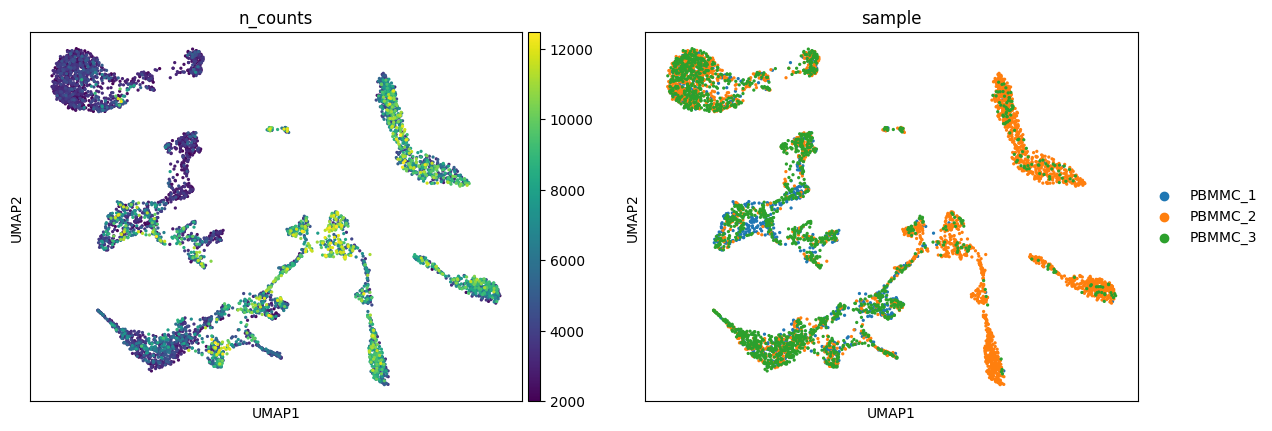

In [7]:
sc.pl.umap(adata, color=['n_counts', 'sample'])

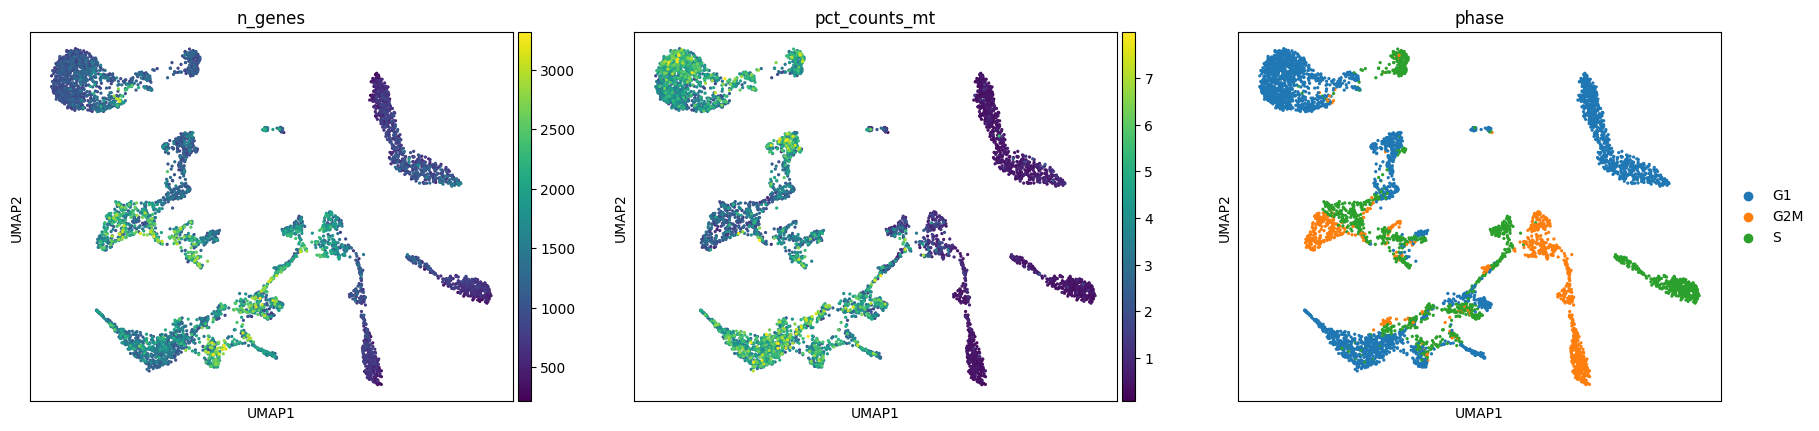

In [8]:
sc.pl.umap(adata, color=['n_genes', 'pct_counts_mt', 'phase'])

**Exercise 4**: Let’s proceed with Leiden clustering and UMAP embeddings for the time being.

- Create a new metadata attribute for your current clusters, i.e. `adata.obs["leiden_res1"] = adata.obs["leiden"]`.
- Repeat leiden clustering using different values for the resolution parameter: `0.1`, `0.5`, `2.0`.
- Save the clusters in a new metadata column and visualize them on the UMAP representation.
- How does the number of clusters change with adjustments to the resolution parameter? Using the resolution=1 as a basis, do any clusters divide into two smaller clusters upon changing the resolution parameter? Do any clusters merge together? Can you plot the three different clustering results side-by-side on the UMAP to compare?

In [9]:
adata.obs["leiden_res1"] = adata.obs["leiden"]

In [10]:
sc.tl.leiden(adata, key_added="leiden_res0_1", resolution=0.1)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res2", resolution=2)

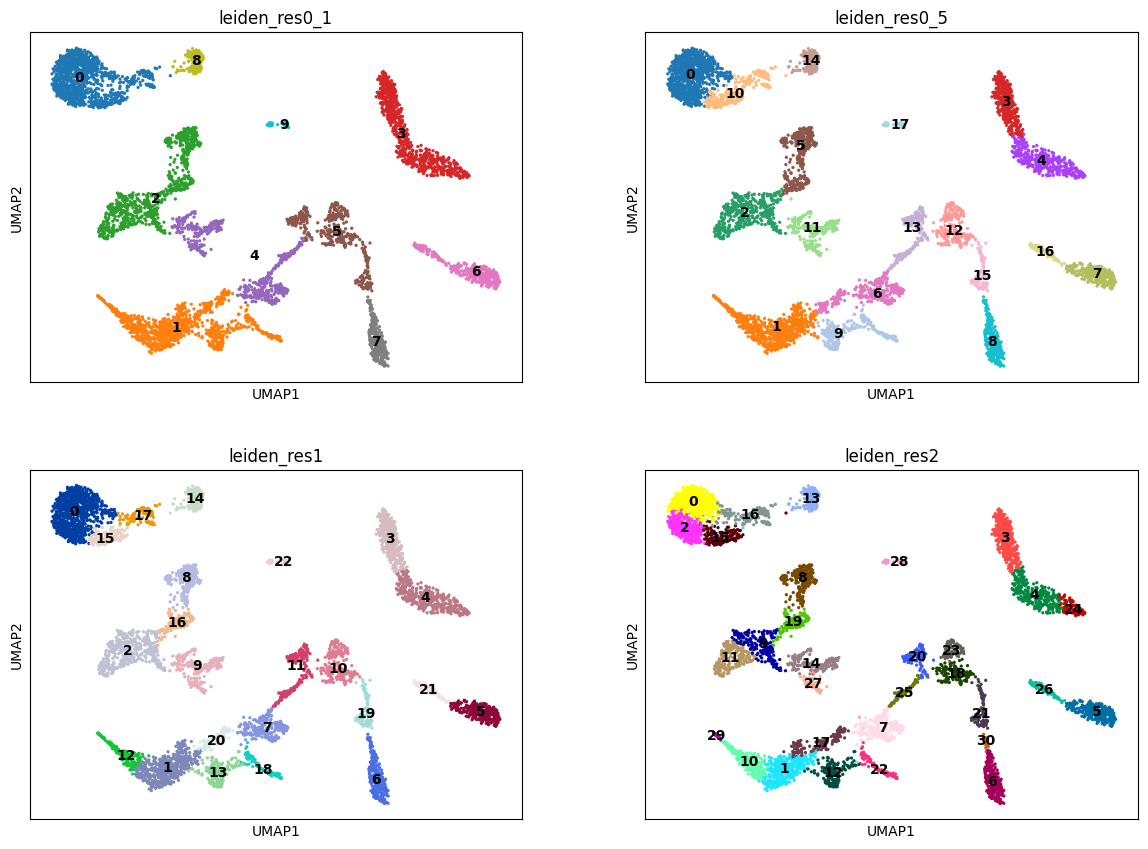

In [11]:
sc.pl.umap(
    adata,
    color=["leiden_res0_1", "leiden_res0_5", "leiden_res1", "leiden_res2"],
    legend_loc="on data",
    ncols=2,
)

**OPTIONAL Exercise 5**: Let’s take a few steps back to understand the previous steps a little bit better! For example, the number of principal components used in computing the neighborhood graph will greatly impact the visualizations. Rerun previous code using the following number of PCs and visualize the different UMAPs and number of clusters: 4 PCs, 8 PCs, 15 PCs, 30 PCs. What changes with the different number of PCs used? Choose an “optimal” number of PCs by examining the contribution of each PC to the total variance with the command: sc.pl.pca_variance_ratio(adata, log=True).

In [ ]:
# Apply for 4 PCs
sc.pp.neighbors # you must complete
sc.tl.umap # you must complete
sc.tl.leiden # you must complete
sc.pl.umap(adata_scvi, color=["leiden"])

In [ ]:
# Apply for 8 PCs

In [ ]:
# Apply for 15 PCs

In [ ]:
# Apply for 30 PCs

# Visualization and cell type annotation

Before proceeding with marker gene analysis and cell type annotation, restore the raw version of the data, add the necessary annotations, and normalize the counts:

In [12]:
adata_raw = sc.read_h5ad("PBMC_analysis_SIB_tutorial.h5ad") # raw data before selecting highly variable genes
adata_raw_norm = adata_raw.copy()
sc.pp.normalize_total(adata_raw_norm, target_sum=None)
sc.pp.log1p(adata_raw_norm)

In [13]:
adata_raw_norm.obs["leiden"] = adata.obs["leiden_res1"]
adata_raw_norm.obsm["X_pca"] = adata.obsm["X_pcahm"]
adata_raw_norm.obsm["X_umap"] = adata.obsm["X_umap"]

Let’s use a simple method implemented by scanpy to find marker genes by the Leiden cluster.

In [14]:
sc.tl.rank_genes_groups(
    adata_raw_norm, use_raw=False, groupby="leiden", method="wilcoxon", key_added="dea_leiden"
)

/home/alex/anaconda3/envs/sib_course_2024/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/alex/anaconda3/envs/sib_course_2024/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/alex/anaconda3/envs/sib_course_2024/lib/python3.9/site-packages/scanpy/tools/_rank_genes_grou

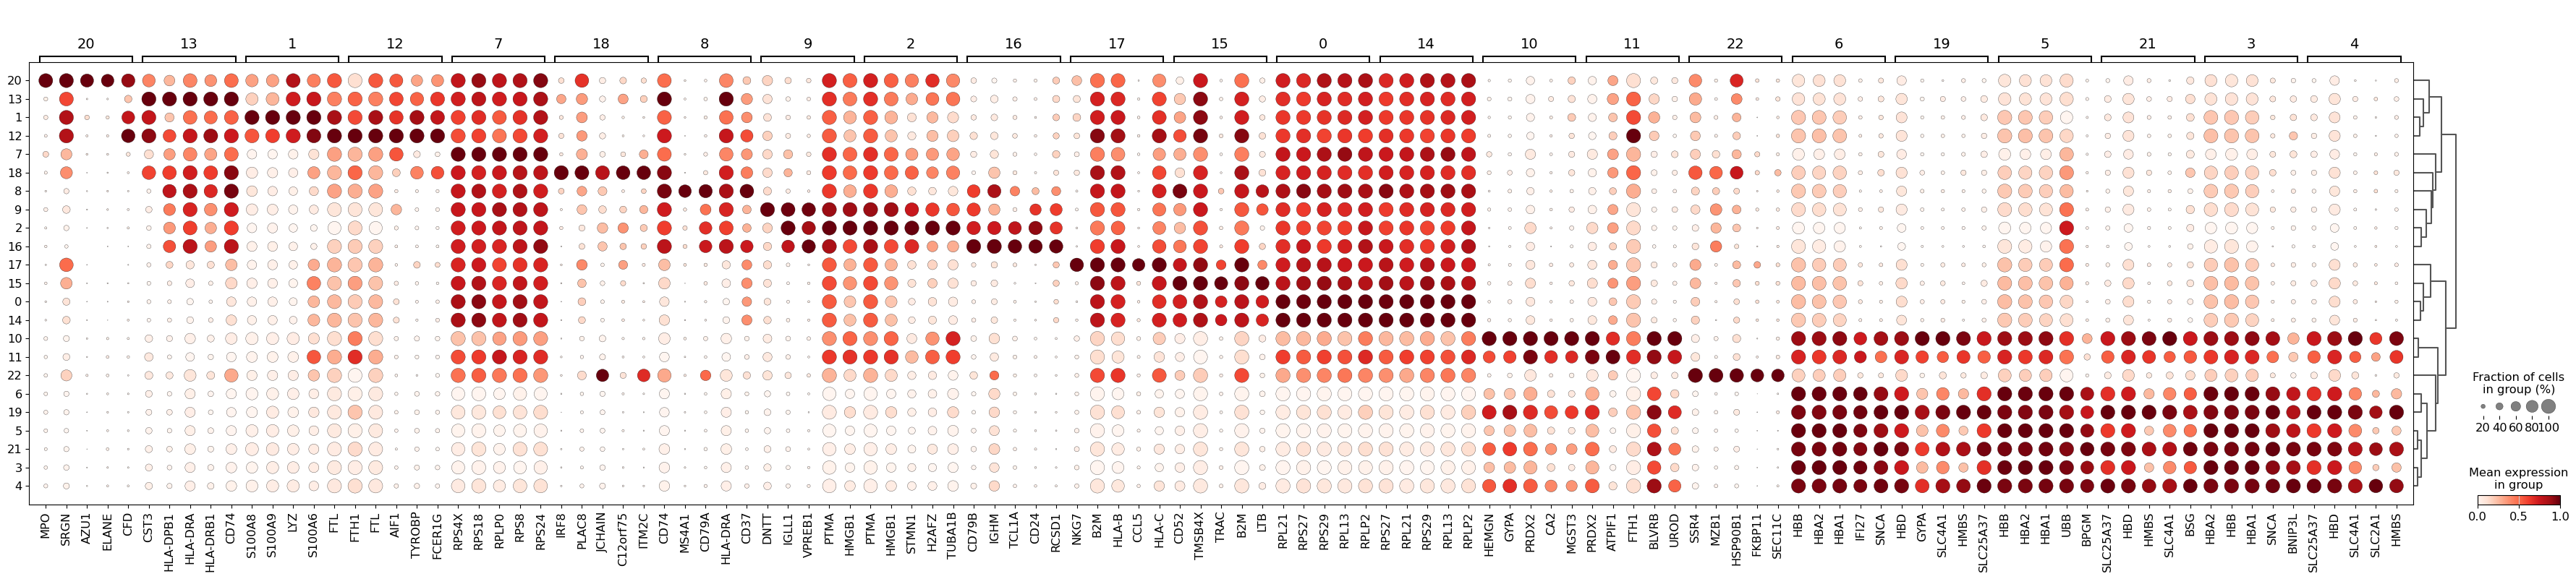

In [15]:
sc.settings.set_figure_params(dpi=50, facecolor='white')
sc.pl.rank_genes_groups_dotplot(
    adata_raw_norm, groupby="leiden", standard_scale="var", n_genes=5, key="dea_leiden"
)

As you can see above, a lot of the differentially expressed genes are highly expressed in multiple clusters. We can filter the differentially expressed genes to select for more cluster-specific differentially expressed genes:

In [16]:
sc.tl.filter_rank_genes_groups(
    adata_raw_norm,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key="dea_leiden",
    key_added="dea_leiden_filtered",
)

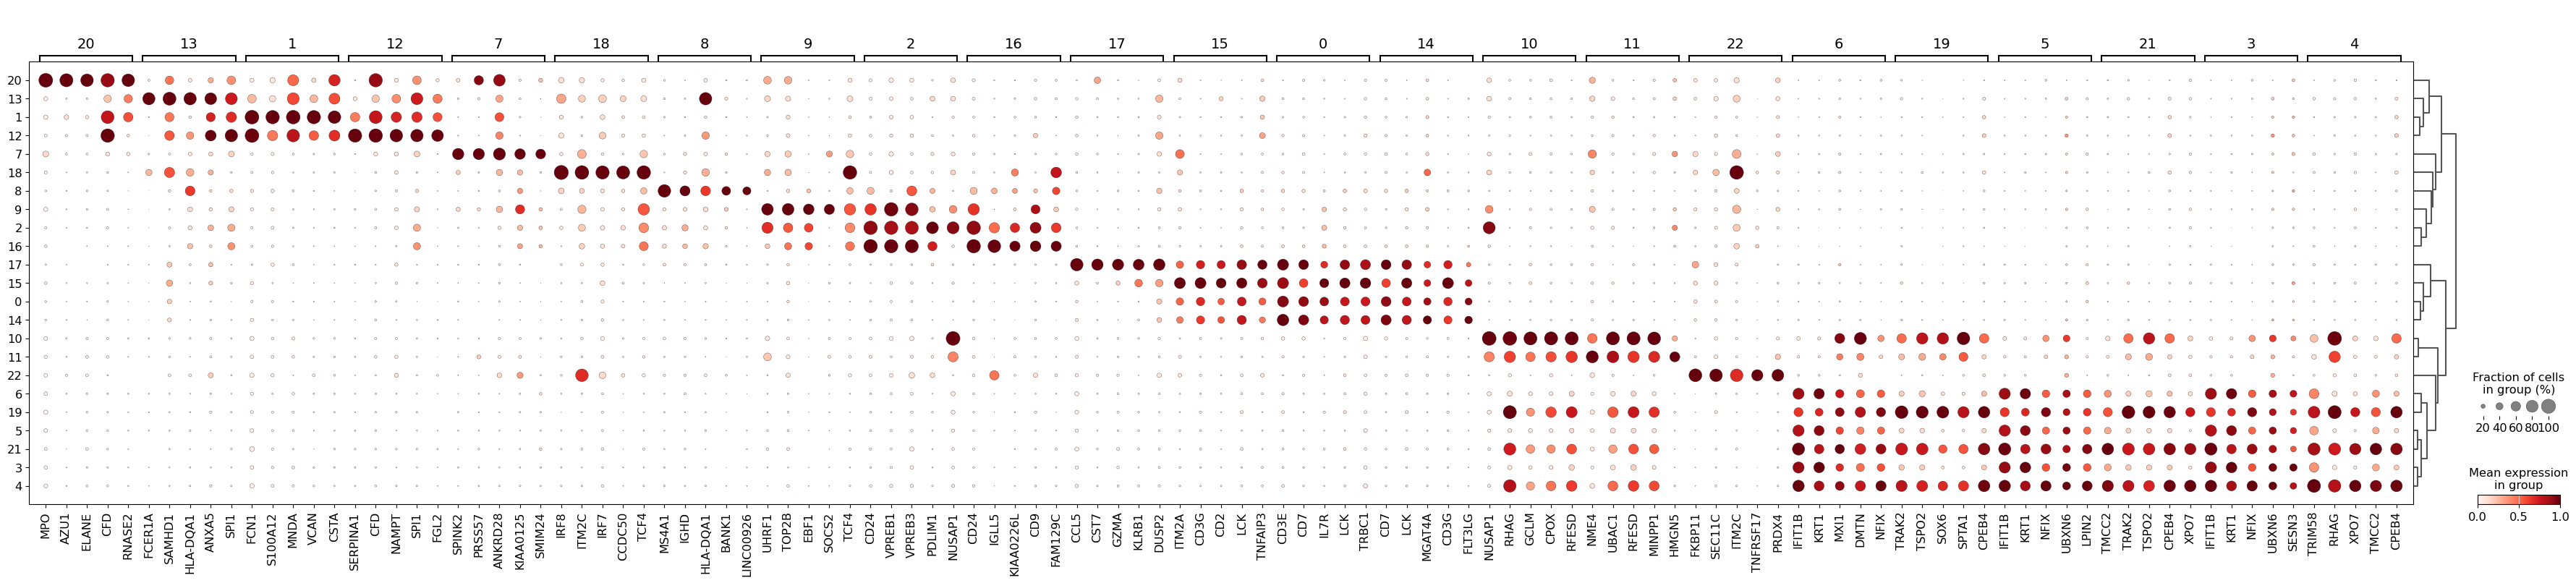

In [17]:
sc.pl.rank_genes_groups_dotplot(
    adata_raw_norm, groupby="leiden", standard_scale="var", n_genes=5, key="dea_leiden_filtered"
)

**Exercise 6**: Visualize marker genes on the UMAP or tSNE representation. Try to find 3-4 marker genes that are indeed specific to a particular cluster. Are there any clusters that do not seem to have unique marker genes? Are there any clusters containing markers that are only specific to a portion of the cluster? Marker genes should uniformly define cells "everywhere" in a cluster in UMAP space, otherwise the cluster might actually be two!

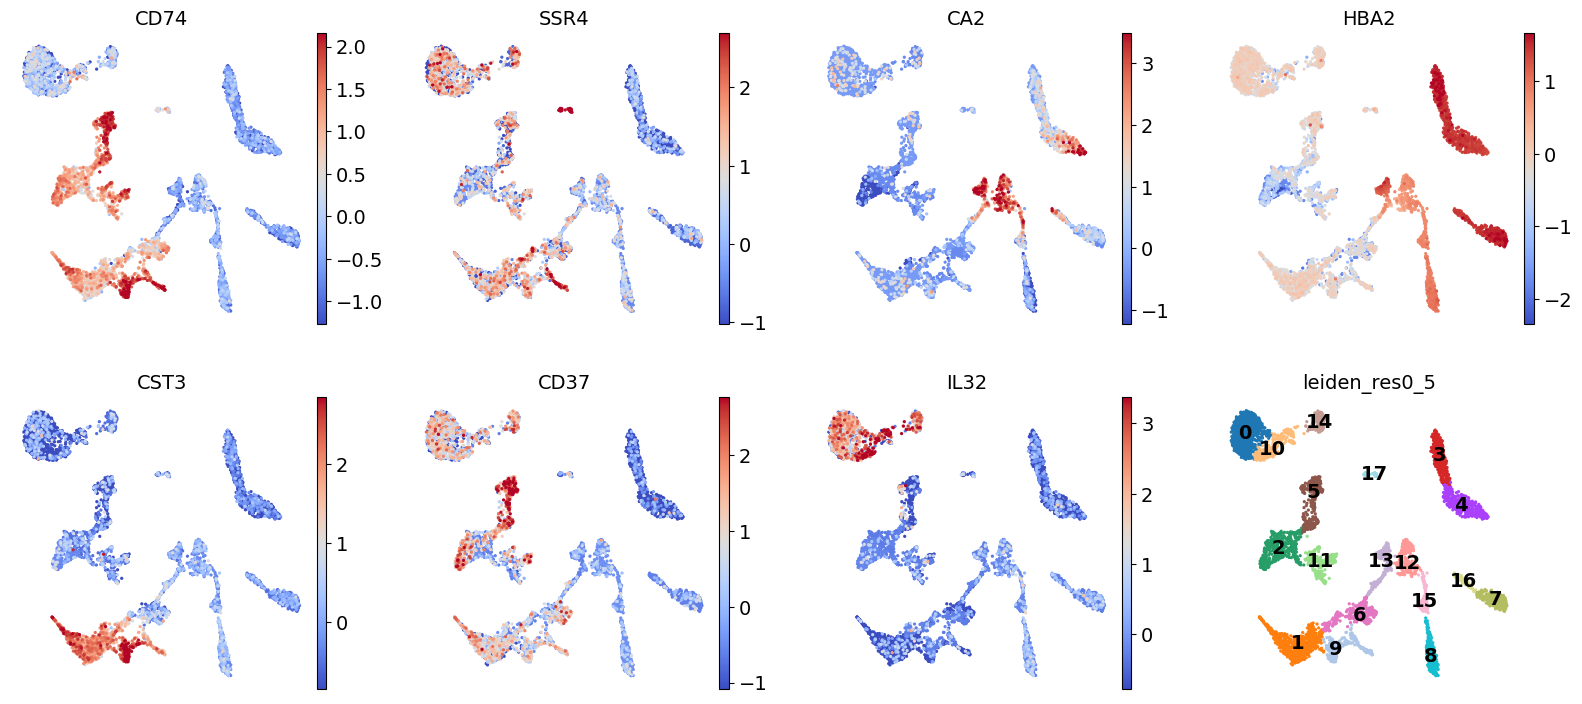

In [18]:
sc.pl.umap(
    adata,
    color=["CD74", "SSR4", "CA2", "HBA2", "CST3", "CD37", "IL32", "leiden_res0_5"],
    vmax="p99",
    legend_loc="on data",
    frameon=False,
    cmap="coolwarm",
)

**Exercise 7 (optional)**: Let’s take a few steps back to understand all of the previous steps a little bit better! The number of genes selected by the highly_variable_genes function can significantly impact your ability to cluster. Too few genes and you cannot discriminate between different cell types, too many genes and you capture lots of noisy clusters! Try repeating the previous analysis with either 200 or 5000 highly variable genes, naming the AnnData object differently (i.e. adata_200genes) to avoid overwriting your previous results. Transfer the metadata for the new cluster labels to the original AnnData object's metadata at adata.obs and compare on the UMAP. Are the clusters different?

Once you have settled on the parameters for the dimensionality reduction and clustering steps, it is time to begin annotating your clusters with cell types. This is normally a challenging step! When you are not too familiar with the marker genes for a particular cluster, a good starting point is simply to Google a strong marker gene and understand its function. Other tools that might be useful include EnrichR and GSEAPy.
- https://maayanlab.cloud/Enrichr/
- https://gseapy.readthedocs.io/en/latest/gseapy_example.html#2.-Enrichr-Example

Fortunately in our case, we will try automated cell type annotations!

# Automated cell type annotation



**Exercise 8** The methods discussed here focus on automated data annotation, distinct from manual methods. Unlike the previously detailed approach, these methods automate data annotation. They operate on different principles, using predefined markers or trained on comprehensive scRNA-seq datasets. It's vital to note that automated annotations can vary in quality. Thus, they should be seen as a starting point rather than a final solution. [Pasquini et al., 2021](https://www.csbj.org/article/S2001-03702100019-2/fulltext) and [Abdelaal et al., 2019](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1795-z) offer extensive discussions on automated annotation methods.

Quality depends on:

- Classifier Choice: Various classifier types perform similarly, with neural networks __not__ necessarily outperforming linear models [[1](https://www.csbj.org/article/S2001-03702100019-2/fulltext), [2](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1795-z), [3](https://academic.oup.com/bib/article/22/5/bbab035/6145135?login=false)].

- Training Data Quality: Annotation quality relies on the quality of the training data. Poorly annotated or noisy training data can impact the classifier.

- Data Similarity: Similarity between your data and the classifier's training data matters. Cross-dataset models often provide better annotations. For example, CellTypist, trained on diverse lung datasets, is likely to perform well on new lung data.

While classifiers have limitations, they offer advantages like rapid annotation, leveraging previous studies, and promoting standardized terminology. Ensuring robust uncertainty measures to quantify annotation reliability is crucial.

Many classification methods rely on a limited set of genes, typically just 1 to ~10 marker genes per cell type. An alternative approach utilizes classifiers that consider a more extensive gene set, often several thousands or more. These classifiers are trained on previously annotated datasets or atlases. Notable examples include CellTypist [Conde et al., 2022](https://www.science.org/doi/full/10.1126/science.abl5197) and Clustifyr [Fu et al., 2020](https://f1000research.com/articles/9-223/v2).

Let's explore CellTypist for our data. Referring to the [CellTypist tutorial](https://www.celltypist.org/tutorials), we should prepare our data by normalizing counts to 10,000 counts per cell and subsequently applying a log1p transformation. So we need to re-normalize our data, without our logarithm shift approach, but with a more classical 'Counts per ten-thousand'.

In [19]:
import re
import celltypist
from celltypist import models

In [20]:
adata_celltypist = adata_raw.copy()  # make a copy of our adata
sc.pp.normalize_per_cell(
    adata_celltypist, counts_per_cell_after=10000.0
)  # normalize to 10,000 counts per cell
sc.pp.log1p(adata_celltypist)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:
adata_celltypist.X = adata_celltypist.X

Here we will load the model directly from our folder on google drive, where we can find the model trained. Alternatively, CellTypist method propose a panel of models that can be download directly from python using `models.download_models(force_update = True)`. The idea is of course to use a model that match our biological context, and for pre-trained model-based method like CellTypist, it is possible that your biological context is not available. In that situation, there is no other options than opting for manual annotations.

There are two models that might be relevant for this particular dataset we are working with. Let's download both of them and try each one for the classification.

In [21]:
models.download_models(
    force_update=True, model=["Immune_All_Low.pkl", "Immune_All_High.pkl"]
)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 46
📂 Storing models in /home/alex/.celltypist/data/models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl


In [22]:
model_low = models.Model.load(model="Immune_All_Low.pkl")
model_high = models.Model.load(model="Immune_All_High.pkl")

For each of these, we can see which cell types it includes to see if bone marrow cell types are included:

In [23]:
# We can print all the cell types covererd by the model
model_low.cell_types

array(['Age-associated B cells', 'Alveolar macrophages', 'B cells',
       'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', 'CD8a/b(entry)',
       'CMP', 'CRTAM+ gamma-delta T cells', 'Classical monocytes',
       'Cycling B cells', 'Cycling DCs', 'Cycling NK cells',
       'Cycling T cells', 'Cycling gamma-delta T cells',
       'Cycling monocytes', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Erythrophagocytic macrophages', 'Fibroblasts',
       'Follicular B cells', 'Follicular helper T cells', 'GMP',
       'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1', 'ILC2', 'ILC3',
       'Intermediate macrophages', 'Intestinal macrophages',
       'Kidney-resident macrophages', 'Kupffer cells',
       'Large pre-B cell

In [24]:
# We can print all the cell types covererd by the model
model_high.cell_types

array(['B cells', 'B-cell lineage', 'Cycling cells', 'DC', 'DC precursor',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ETP',
       'Early MK', 'Endothelial cells', 'Epithelial cells',
       'Erythrocytes', 'Erythroid', 'Fibroblasts', 'Granulocytes',
       'HSC/MPP', 'ILC', 'ILC precursor', 'MNP', 'Macrophages',
       'Mast cells', 'Megakaryocyte precursor',
       'Megakaryocytes/platelets', 'Mono-mac', 'Monocyte precursor',
       'Monocytes', 'Myelocytes', 'Plasma cells', 'Promyelocytes',
       'T cells', 'pDC', 'pDC precursor'], dtype=object)

The model_high seems to have fewer cell types, let's start with that for obtaining broader cell type categories.

In [25]:
predictions_high = celltypist.annotate(
    adata_celltypist, model=model_high, majority_voting=True
)

🔬 Input data has 5469 cells and 10841 genes
🔗 Matching reference genes in the model
🧬 3731 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
/home/alex/anaconda3/envs/sib_course_2024/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [26]:
predictions_high_adata = predictions_high.to_adata()
predictions_high_adata.obs[['majority_voting', 'conf_score']]

,majority_voting,conf_score
AAACCTGCAGACGCAA-1,B cells,0.997790
AAACCTGTCATCACCC-1,T cells,0.986443
AAAGATGCATAAAGGT-1,Monocytes,0.961658
AAAGCAAAGCAGCGTA-1,T cells,0.999908
AAAGCAACAATAACGA-1,T cells,0.994181
...,...,...
TTTGTCACAATGAAAC-1,T cells,0.999788
TTTGTCACATCTGGTA-1,B cells,0.999942
TTTGTCAGTACAGCAG-1,T cells,0.828790
TTTGTCAGTGTGAATA-1,B-cell lineage,0.970384


In [27]:
adata_raw_norm.obs["celltypist_annotations_high"] = predictions_high_adata.obs["majority_voting"]
adata_raw_norm.obs["celltypist_conf_score_high"] = predictions_high_adata.obs["conf_score"]

Now let's do the same for the finer-grained annotations

In [28]:
predictions_low = celltypist.annotate(
    adata_celltypist, model=model_low, majority_voting=True
)

🔬 Input data has 5469 cells and 10841 genes
🔗 Matching reference genes in the model
🧬 3731 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [29]:
predictions_low_adata = predictions_low.to_adata()
predictions_low_adata.obs[['majority_voting', 'conf_score']]

,majority_voting,conf_score
AAACCTGCAGACGCAA-1,B cells,0.731157
AAACCTGTCATCACCC-1,Tcm/Naive cytotoxic T cells,0.975580
AAAGATGCATAAAGGT-1,Classical monocytes,0.532938
AAAGCAAAGCAGCGTA-1,Tcm/Naive helper T cells,0.998210
AAAGCAACAATAACGA-1,Tcm/Naive cytotoxic T cells,0.809559
...,...,...
TTTGTCACAATGAAAC-1,Tcm/Naive cytotoxic T cells,0.946592
TTTGTCACATCTGGTA-1,Naive B cells,0.341540
TTTGTCAGTACAGCAG-1,Tcm/Naive cytotoxic T cells,0.135967
TTTGTCAGTGTGAATA-1,Large pre-B cells,0.217258


And we save our predictions to our AnnData object:

In [30]:
adata_raw_norm.obs["celltypist_annotations_low"] = predictions_low_adata.obs["majority_voting"]
adata_raw_norm.obs["celltypist_conf_score_low"] = predictions_low_adata.obs["conf_score"]

CellTypist annotations can then be visualized on the UMAP embedding:

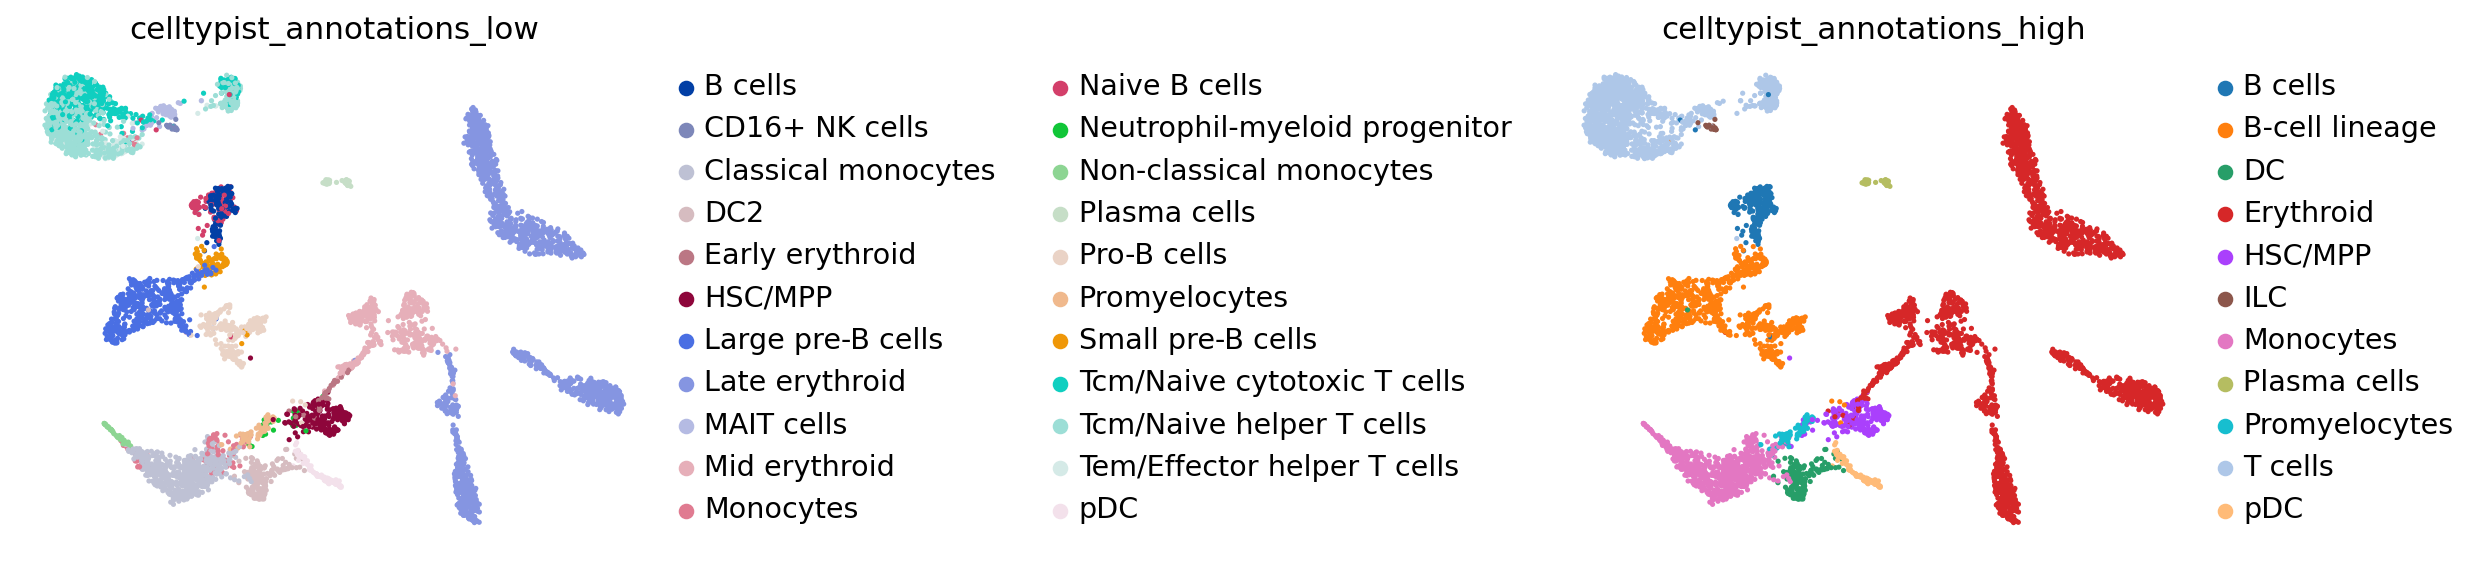

In [35]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pl.umap(
    adata_raw_norm,
    color=["celltypist_annotations_low", "celltypist_annotations_high"],
    frameon=False,
    sort_order=False,
    wspace=1.2,
)

Also, each cell gets a prediction score:

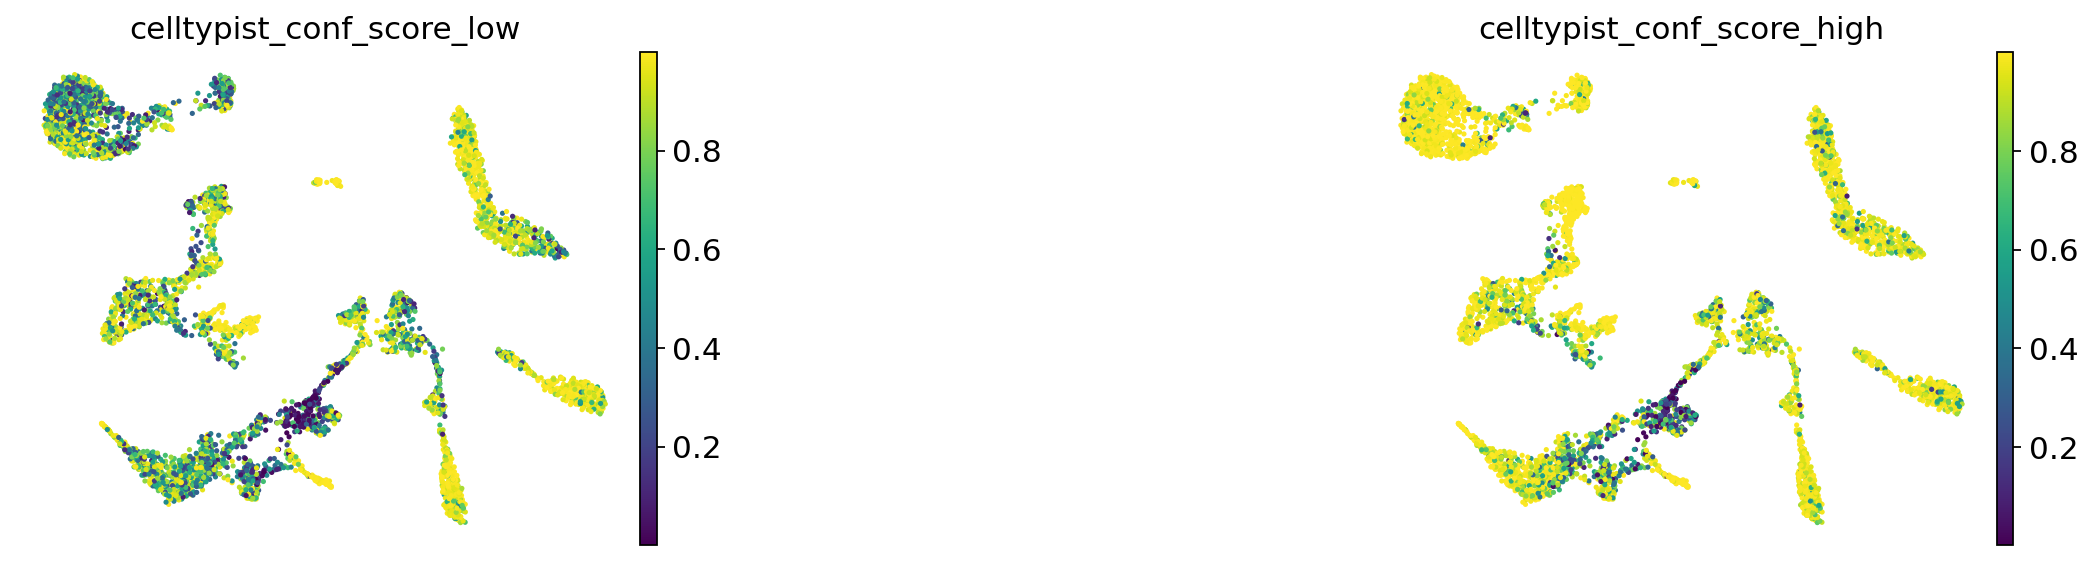

In [32]:
sc.pl.umap(
    adata_raw_norm,
    color=["celltypist_conf_score_low", "celltypist_conf_score_high"],
    frameon=False,
    sort_order=False,
    wspace=1,
)

One way of getting a feeling for the quality of these annotations is by looking if the observed cell type similarities correspond to our expectations:

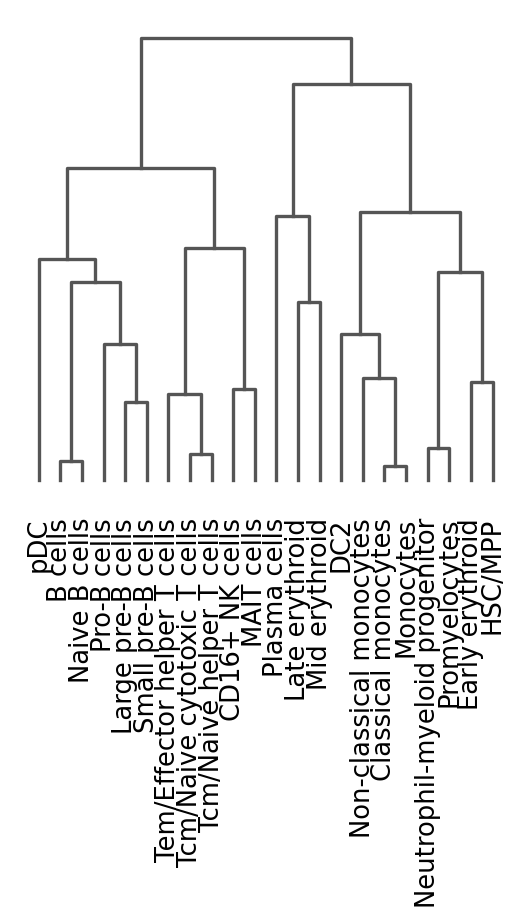

<Axes: >

In [33]:
sc.pl.dendrogram(adata_raw_norm, groupby="celltypist_annotations_low")

# Another way to annotate: with label transfer from a reference dataset!

In [38]:
# To be added for the diseased conditions...

In [40]:
del adata_raw_norm.uns["dea_leiden_filtered"]

In [41]:
adata_raw_norm.write_h5ad("PBMC_analysis_SIB_tutorial5.h5ad")